In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, somatic_mut_clock
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr
from scipy import stats
import dask

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

# Get data

In [3]:
out_dir = "./output_dirs/output_120522"
dependency_f_dir = "./dependency_files"
data_dir = "./data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [11]:
# read in other already computed files
# from running analysis.main() 
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
# add ages to all_methyl_df_t
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)


# Somatic mutation clock

In [ ]:
# For each CpG
# STEP 1: Filter to mutated sites on same chr
# STEP 2: predictor_sites:
#   most correlated
#   the site itself
#   any site from databases that affect the CpG
#   all sites within 2kb window
#   all sites with significant association 
# STEP 3: train linear model on the mutation status of predictor_sites
#   elasticNet bc greedily including many features 

In [ ]:
# build a seperate predictor for each tissue type and sex
# OR include these as variables in model

In [23]:
mut_clock = somatic_mut_clock.mutationClock(
    all_mut_w_age_df, 
    illumina_cpg_locs_df, 
    all_methyl_age_df_t
    )

In [ ]:
# took 1:45min to run 50 sites
for cpg_id in all_methyl_age_df_t.columns[2:52].to_list():
    predictor_sites = mut_clock.get_predictor_sites(
        cpg_id = cpg_id, num_correl_sites = 1000,
        max_meqtl_sites = 1000, nearby_window_size = 2000
        )
    mut_clock.train_one_predictor(cpg_id = cpg_id, predictor_sites = predictor_sites)

In [30]:
predictor_sites = mut_clock.get_predictor_sites(
    cpg_id = 'cg00000363', num_correl_sites = 1000,
    max_meqtl_sites = 1000, nearby_window_size = 2000
    )

got 1000 correlated sites
got 4001 nearby sites
got 5 db sites
got 55 matrixQTL sites
number of overlapping sites between correlated and nearby: 3
number of overlapping sites between correlated and db: 0
number of overlapping sites between correlated and matrixQTL: 0
number of overlapping sites between nearby and correlated: 3
number of overlapping sites between nearby and db: 0
number of overlapping sites between nearby and matrixQTL: 0
number of overlapping sites between db and correlated: 0
number of overlapping sites between db and nearby: 0
number of overlapping sites between db and matrixQTL: 0
number of overlapping sites between matrixQTL and correlated: 0
number of overlapping sites between matrixQTL and nearby: 0
number of overlapping sites between matrixQTL and db: 0
got 5058 total predictor sites


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/frame.py:3636: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


MAE: 0.10010360984366398
r2: 0.5449685542723883
coefficients: [ 2.20767147e-01  1.12340874e-01  1.27481133e-01  1.67485486e-02
  7.37599071e-02 -4.67666427e-04  6.21652894e-02  1.20546716e-01
  1.88752454e-02  5.63909268e-01  1.10215150e-01  1.55861859e-01
  2.35247233e-01  5.76271869e-01  1.03702183e-01  1.02559430e-01
  8.20919964e-02  1.23865992e-01 -9.39242180e-03  1.76946180e-01
  2.09155546e-02  3.26039559e-01  1.29401643e-01  1.31570001e-01
  1.68881404e-01  2.04906864e-01  5.00050387e-02  3.96512155e-01
  2.99400246e-02  4.56394795e-02  1.76619671e-01  1.66615504e-02
  3.18249853e-02 -1.61890623e-01  5.84634361e-02  8.77472468e-02
  2.39397249e-01  1.93256764e-01  1.67759725e-01  5.22895065e-01
  4.86854878e-03  1.46589537e-01 -2.59036284e-02  2.96555005e-04
  1.82989640e-01 -7.67669625e-02  2.49827329e-02  1.31531614e-03
  1.09735896e-01  2.77732652e-02  3.11793509e-01  5.06153818e-02
 -1.89438163e-02 -7.17807880e-02 -2.79366533e-02 -1.55536160e-02
  9.37010884e-02  3.27632023

ElasticNetCV(cv=3, random_state=0)

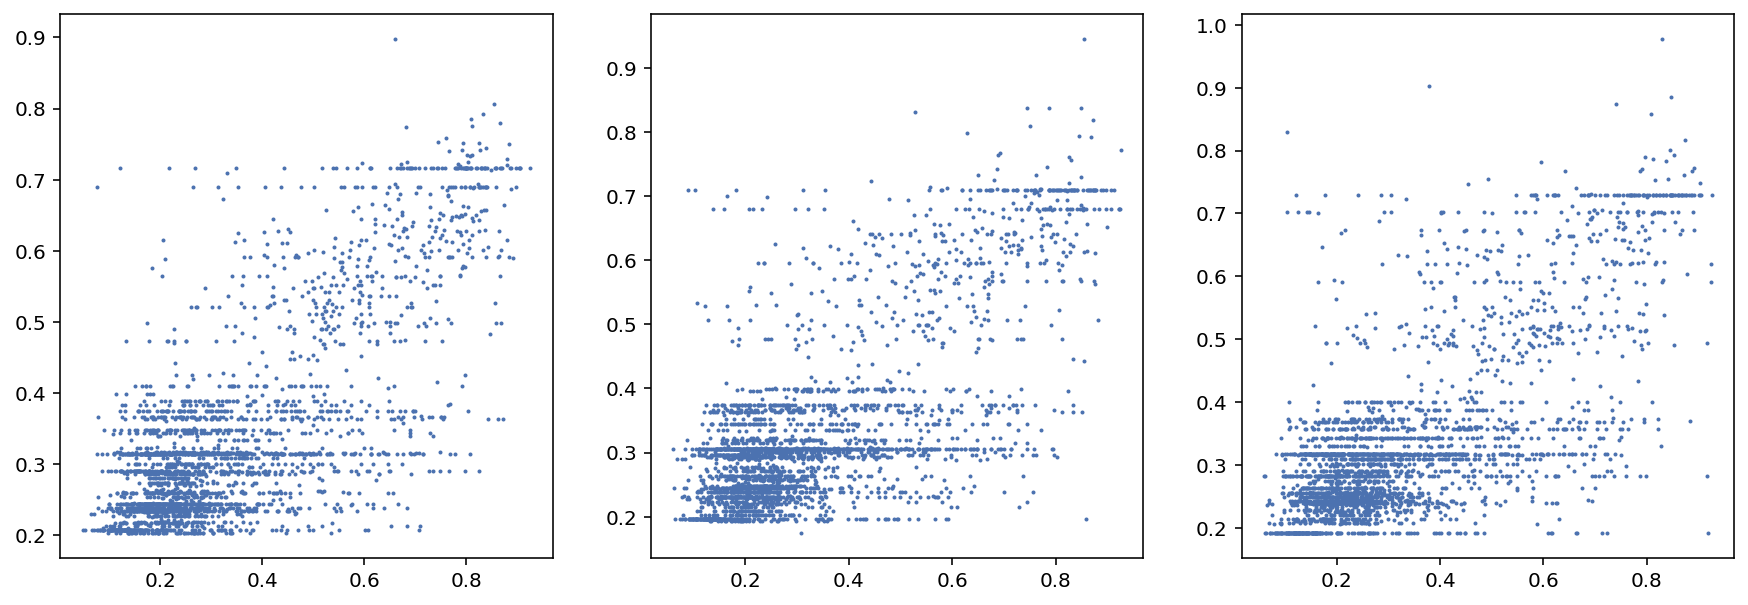

In [37]:
mut_clock.train_one_predictor(cpg_id = 'cg00000363', predictor_sites = predictor_sites)

/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/frame.py:3636: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


MAE: 0.10517377034444553
r2: 0.5086813772165173
coefficients: [-0.02353012  0.0007433   0.15218919 -0.07361485  0.01895315  0.07105123
  0.0500955   0.26299382  0.0387271  -0.00091179 -0.07065429 -0.00072835
 -0.01266273  0.07979542  0.16037355  0.39444909 -0.02676906 -0.06800524
 -0.07411517 -0.05502759 -0.10552736 -0.00744995  0.06362586  0.32605661
  0.05637427 -0.05594156 -0.05747017  0.00111411 -0.04969316  0.21095477]
feature names: Index(['gender_FEMALE', 'gender_MALE', 'dataset_ACC', 'dataset_BLCA',
       'dataset_BRCA', 'dataset_CHOL', 'dataset_COAD', 'dataset_DLBC',
       'dataset_ESCA', 'dataset_GBM', 'dataset_HNSC', 'dataset_KICH',
       'dataset_KIRC', 'dataset_LAML', 'dataset_LGG', 'dataset_LIHC',
       'dataset_LUAD', 'dataset_LUSC', 'dataset_PAAD', 'dataset_PCPG',
       'dataset_PRAD', 'dataset_READ', 'dataset_SARC', 'dataset_SKCM',
       'dataset_STAD', 'dataset_TGCT', 'dataset_THCA', 'dataset_THYM',
       'dataset_UCEC', 'dataset_UVM'],
      dtype='object')
in

ElasticNetCV(cv=3, random_state=0)

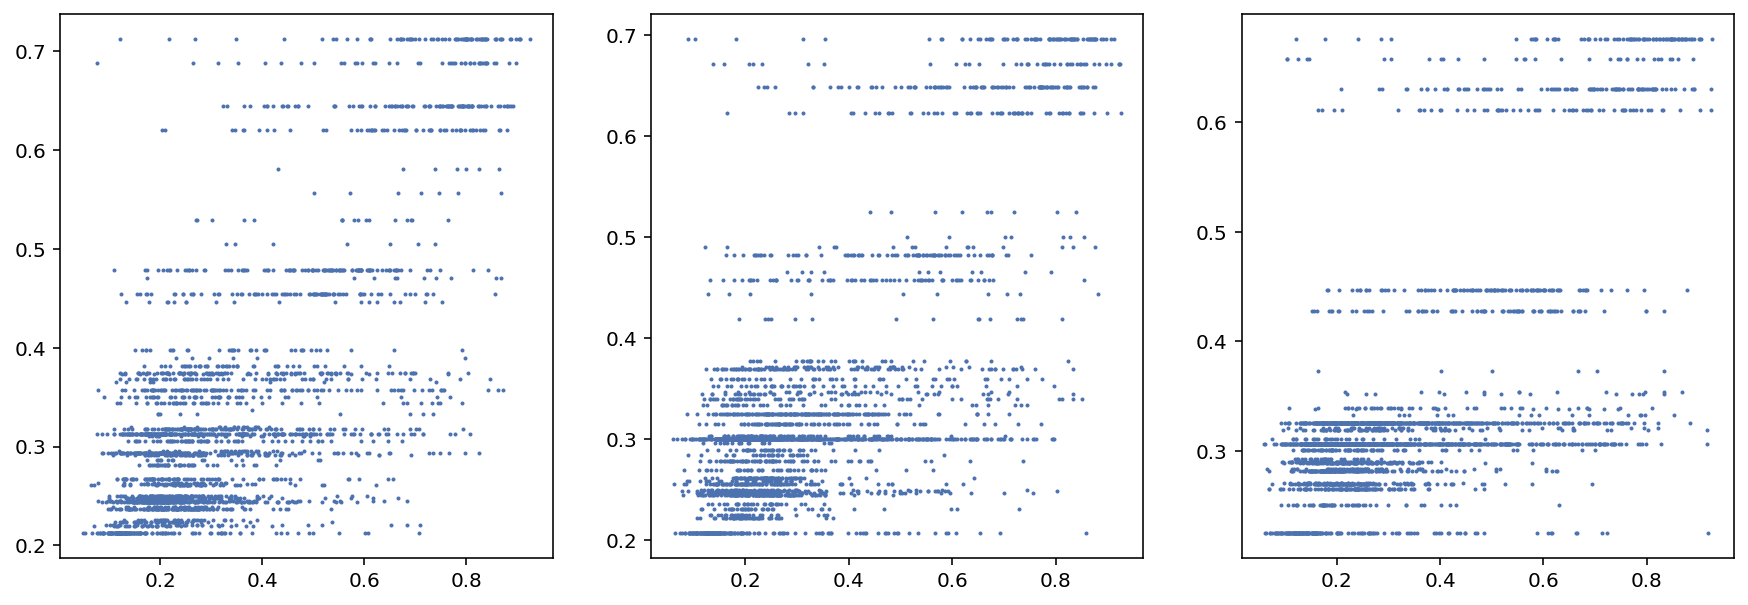

In [38]:
mut_clock.train_one_predictor(cpg_id = 'cg00000363', predictor_sites = predictor_sites)